<a href="https://colab.research.google.com/github/dima1115/Machine-learning/blob/main/%D0%94%D0%B0%D1%80%D0%BC%D0%BE%D1%81%D1%82%D1%83%D0%BA_%D0%BF%D1%802_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторна робота 2
Тема: Аналіз даних. Бібліотека Pandas  
Варіант: 6  
Автор: Дармостук Дмитро, група ФІТ‑4‑9

Нижче наведено повне виконання двох завдань.
Усі кроки супроводжені коментарями. Наприкінці кожного завдання — окремий висновок.

In [17]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 50)
pd.set_option('mode.copy_on_write', True)
np.random.seed(6)

## Завдання 1. ВВП країн (Вікіпедія)

In [18]:
import pandas as pd, requests

url = 'https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)'
headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 '
                         '(KHTML, like Gecko) Chrome/120.0 Safari/537.36'}

html = requests.get(url, headers=headers, timeout=30).text
tables = pd.read_html(html)  # парсимо вже отриманий HTML

gdp_raw = None
for t in tables:
    cols = [str(c).lower() for c in t.columns]
    if any('country' in c for c in cols) and any('imf' in c for c in cols) and any('world' in c for c in cols):
        gdp_raw = t.copy()
        break

assert gdp_raw is not None, 'Не знайшов потрібну таблицю на сторінці'
gdp_raw.head()


/tmp/ipython-input-2917050499.py:8: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(html)  # парсимо вже отриманий HTML


,Country/Territory,IMF (2025)[1][6],World Bank (2022–24)[7],United Nations (2023)[8]
0,World,117165394,111326370,100834796
1,United States,30616743,29184890,27720700
2,China[n 1],19398577,18743803,17794782
3,Germany,5014786,4659929,4525704
4,Japan,4280575,4026211,4204495


In [19]:
df = gdp_raw.copy()
df.columns = [str(c).strip() for c in df.columns]
colmap = {}
for c in df.columns:
    cl = c.lower()
    if 'country' in cl:
        colmap[c] = 'Country'
    elif 'imf' in cl or 'fund' in cl:
        colmap[c] = 'MVF_2024'
    elif 'world bank' in cl:
        colmap[c] = 'WorldBank_2023'
    elif 'un' in cl:
        colmap[c] = 'OON_2022'
    else:
        colmap[c] = c
df = df.rename(columns=colmap)
df = df[[c for c in ['Country','MVF_2024','WorldBank_2023','OON_2022'] if c in df.columns]]
display(df.head())
print('shape:', df.shape)
print(df.dtypes)

,Country,MVF_2024,WorldBank_2023,OON_2022
0,World,117165394,111326370,100834796
1,United States,30616743,29184890,27720700
2,China[n 1],19398577,18743803,17794782
3,Germany,5014786,4659929,4525704
4,Japan,4280575,4026211,4204495


shape: (222, 4)
Country           object
MVF_2024          object
WorldBank_2023    object
OON_2022          object
dtype: object


In [20]:
def to_number(x):
    if pd.isna(x):
        return np.nan
    s = str(x)
    for ch in ['—','–',',','\xa0','†','*']:
        s = s.replace(ch,'')
    try:
        return float(s)
    except:
        return np.nan

num_cols = [c for c in df.columns if c!='Country']
for c in num_cols:
    df[c] = df[c].replace(['—','–'], np.nan).apply(to_number)

print(df[num_cols].isna().sum())
for c in num_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].mean())
print(df[num_cols].isna().sum())

MVF_2024          30
WorldBank_2023    12
OON_2022           9
dtype: int64
MVF_2024          0
WorldBank_2023    0
OON_2022          0
dtype: int64


In [21]:
print('duplicates:', df.duplicated(subset=['Country']).sum())
df = df.drop_duplicates(subset=['Country']).reset_index(drop=True)
display(df.describe())

duplicates: 0


,MVF_2024,WorldBank_2023,OON_2022
count,2.220000e+02,2.220000e+02,2.220000e+02
mean,1.220053e+06,1.053088e+06,9.665418e+05
std,8.210444e+06,7.812285e+06,7.109289e+06
min,6.500000e+01,6.200000e+01,6.800000e+01
25%,1.752200e+04,9.698750e+03,8.888000e+03
50%,8.912300e+04,4.432300e+04,4.088750e+04
75%,6.179125e+05,3.660632e+05,2.939275e+05
max,1.171654e+08,1.113264e+08,1.008348e+08


In [22]:
if set(['MVF_2024','WorldBank_2023']).issubset(df.columns):
    df['Diff_IMF_WB'] = df['MVF_2024'] - df['WorldBank_2023']
    display(df[['Country','Diff_IMF_WB']].set_index('Country').abs().sort_values('Diff_IMF_WB', ascending=False).head(10))

,Diff_IMF_WB
Country,
World,5.839024e+06
United States,1.431853e+06
Saint Martin,1.219404e+06
American Samoa,1.219182e+06
Northern Mariana Islands,1.218957e+06
Sint Maarten,1.218318e+06
Turks and Caicos Islands,1.218308e+06
Curaçao,1.216772e+06
Greenland,1.216726e+06


In [23]:
corr = df.drop(columns=['Country'], errors='ignore').corr(numeric_only=True)
display(corr)

# створюємо копію, яку можна змінювати (додаємо .copy() після .to_numpy())
c2 = corr.to_numpy().copy()
np.fill_diagonal(c2, np.nan)

# повертаємо у DataFrame для зручності
corr2 = pd.DataFrame(c2, index=corr.index, columns=corr.columns)

display(corr2.unstack().dropna().sort_values(ascending=False).head(1))



,MVF_2024,WorldBank_2023,OON_2022,Diff_IMF_WB
MVF_2024,1.000000,0.998812,0.998843,0.730737
WorldBank_2023,0.998812,1.000000,0.999122,0.696609
OON_2022,0.998843,0.999122,1.000000,0.709350
Diff_IMF_WB,0.730737,0.696609,0.709350,1.000000


,,0
OON_2022,WorldBank_2023,0.999122


In [24]:
display(df.drop(columns=['Country'], errors='ignore').mean(numeric_only=True).to_frame('mean'))
df['Std_per_country'] = df.drop(columns=['Country'], errors='ignore').std(axis=1, numeric_only=True)
display(df[['Country','Std_per_country']].sort_values('Std_per_country', ascending=False).head(10))
for c in ['MVF_2024','WorldBank_2023','OON_2022']:
    if c in df.columns:
        imax, imin = df[c].idxmax(), df[c].idxmin()
        print(c, 'max:', df.loc[imax,'Country'], df.loc[imax,c], '| min:', df.loc[imin,'Country'], df.loc[imin,c])

,mean
MVF_2024,1.220053e+06
WorldBank_2023,1.053088e+06
OON_2022,9.665418e+05
Diff_IMF_WB,1.669656e+05


,Country,Std_per_country
0,World,5.240562e+07
1,United States,1.392143e+07
2,China[n 1],9.019537e+06
3,Germany,2.199009e+06
4,Japan,1.960931e+06
5,India,1.871551e+06
6,United Kingdom,1.689703e+06
7,France,1.501653e+06
8,Italy,1.122076e+06
10,Canada,1.091650e+06


MVF_2024 max: World 117165394.0 | min: Tuvalu 65.0
WorldBank_2023 max: World 111326370.0 | min: Tuvalu 62.0
OON_2022 max: World 100834796.0 | min: Tuvalu 68.0


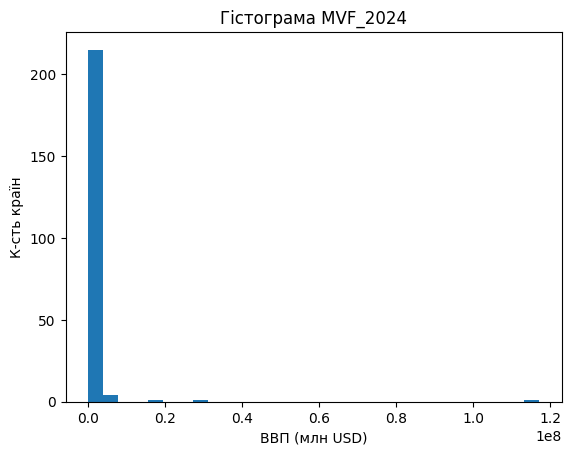

In [25]:
if 'MVF_2024' in df.columns:
    plt.figure()
    df['MVF_2024'].plot(kind='hist', bins=30)
    plt.title('Гістограма MVF_2024')
    plt.xlabel('ВВП (млн USD)')
    plt.ylabel('К-сть країн')
    plt.show()

,Country,MVF_2024,WorldBank_2023,OON_2022
0,World,0.432581,0.476190,0.469934
1,United States,0.113039,0.124836,0.129191
2,China[n 1],0.071621,0.080175,0.082931
3,Germany,0.018515,0.019932,0.021092
4,Japan,0.015804,0.017222,0.019595


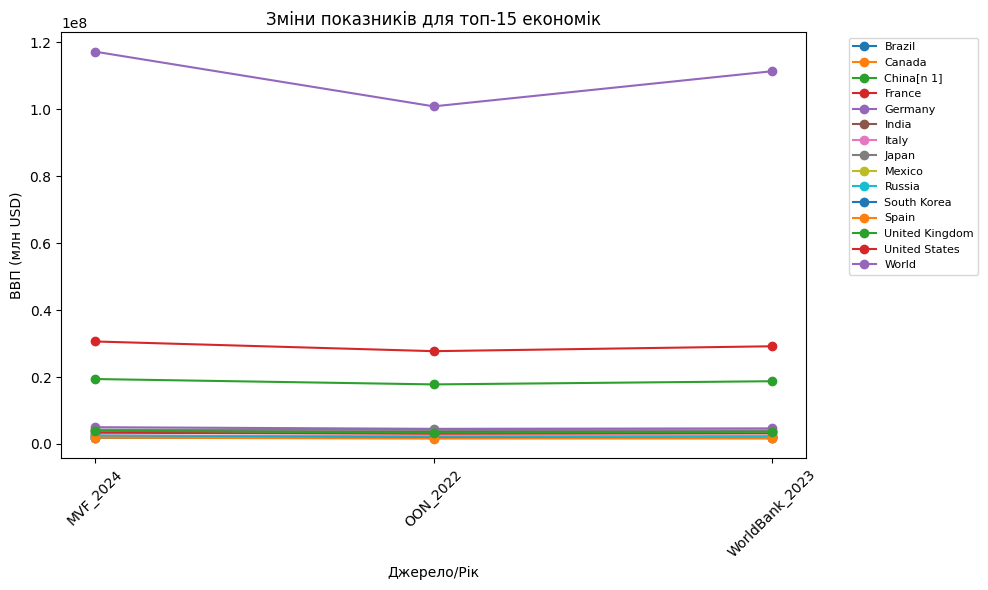

In [26]:
parts = {}
for c in ['MVF_2024','WorldBank_2023','OON_2022']:
    if c in df.columns:
        parts[c] = df[c] / df[c].sum()
share_df = pd.DataFrame(parts)
share_df.insert(0,'Country',df['Country'])
display(share_df.head())

plot_df = df.dropna(subset=['MVF_2024']).nlargest(15,'MVF_2024').copy()
melted = plot_df.melt(id_vars='Country', value_vars=[c for c in ['MVF_2024','WorldBank_2023','OON_2022'] if c in plot_df.columns],
                      var_name='Source_Year', value_name='GDP')
plt.figure(figsize=(10,6))
for country, sub in melted.groupby('Country'):
    sub = sub.sort_values('Source_Year')
    plt.plot(sub['Source_Year'], sub['GDP'], marker='o', label=country)
plt.title('Зміни показників для топ-15 економік')
plt.xlabel('Джерело/Рік')
plt.ylabel('ВВП (млн USD)')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

### Висновок до завдання 1
- Таблицю ВВП прочитано й очищено; пропуски замінено середнім.
- Найбільші розбіжності між джерелами видно в таблиці Top‑10.
- Кореляції між джерелами високі; розподіл має виражені «хвости».

## Завдання 2. Датасет Titanic

In [27]:
from pathlib import Path
def load_titanic():
    p = Path('/content/titanic.csv')
    if p.exists():
        return pd.read_csv(p)
    try:
        import seaborn as sns
        return sns.load_dataset('titanic')
    except Exception:
        pass
    url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
    return pd.read_csv(url)

titanic = load_titanic()
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [28]:
display(titanic.head())
print('shape:', titanic.shape)
print(titanic.dtypes)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


shape: (891, 15)
survived          int64
pclass            int64
sex              object
age             float64
sibsp             int64
parch             int64
fare            float64
embarked         object
class          category
who              object
adult_male         bool
deck           category
embark_town      object
alive            object
alone              bool
dtype: object


In [29]:
print('Пропуски до:')
display(titanic.isna().sum())
num_cols = titanic.select_dtypes(include='number').columns
titanic[num_cols] = titanic[num_cols].fillna(titanic[num_cols].mean())
print('Пропуски після:')
display(titanic.isna().sum())
print('Дублікатів:', titanic.duplicated().sum())
titanic = titanic.drop_duplicates().reset_index(drop=True)
display(titanic.describe(include='all'))

Пропуски до:


,0
survived,0
pclass,0
sex,0
age,177
sibsp,0
parch,0
fare,0
embarked,2
class,0
who,0


Пропуски після:


,0
survived,0
pclass,0
sex,0
age,0
sibsp,0
parch,0
fare,0
embarked,2
class,0
who,0


Дублікатів: 107


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
count,784.000000,784.000000,784,784.000000,784.000000,784.000000,784.000000,782,784,784,784,202,782,784,784
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,3,3,3,2,7,3,2,2
top,NaN,NaN,male,NaN,NaN,NaN,NaN,S,Third,man,True,C,Southampton,no,True
freq,NaN,NaN,491,NaN,NaN,NaN,NaN,568,405,451,451,59,568,461,446
mean,0.411990,2.243622,NaN,29.846335,0.522959,0.415816,34.711740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.492507,0.855056,NaN,13.723868,0.986231,0.836922,52.160151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.000000,1.000000,NaN,22.000000,0.000000,0.000000,8.050000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.000000,3.000000,NaN,29.699118,0.000000,0.000000,15.900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.000000,3.000000,NaN,36.000000,1.000000,1.000000,34.109350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
titanic = titanic.drop(columns=['Cabin','cabin'], errors='ignore')
rename_map = {'survived':'Survived','pclass':'Pclass','sex':'Sex','age':'Age','fare':'Fare'}
titanic = titanic.rename(columns=rename_map)
wanted = ['Survived','Pclass','Sex','Age','Fare']
subset = titanic[[c for c in wanted if c in titanic.columns]].copy()
display(subset.head())

,Survived,Pclass,Sex,Age,Fare
0,0,3,male,22.0,7.2500
1,1,1,female,38.0,71.2833
2,1,3,female,26.0,7.9250
3,1,1,female,35.0,53.1000
4,0,3,male,35.0,8.0500


In [31]:
if 'Sex' in subset.columns:
    subset['Sex'] = subset['Sex'].map({'male':0,'female':1,'Male':0,'Female':1}).astype('float')
subset['Sex'] = subset['Sex'].fillna(subset['Sex'].mode().iloc[0]) if 'Sex' in subset.columns else subset
for c in ['Age','Fare']:
    if c in subset.columns:
        subset[c] = subset[c].fillna(subset[c].mean())
display(subset.isna().sum())
display(subset.head())
display(subset.tail())

,0
Survived,0
Pclass,0
Sex,0
Age,0
Fare,0


,Survived,Pclass,Sex,Age,Fare
0,0,3,0.0,22.0,7.2500
1,1,1,1.0,38.0,71.2833
2,1,3,1.0,26.0,7.9250
3,1,1,1.0,35.0,53.1000
4,0,3,0.0,35.0,8.0500


,Survived,Pclass,Sex,Age,Fare
779,0,3,1.0,39.000000,29.125
780,1,1,1.0,19.000000,30.000
781,0,3,1.0,29.699118,23.450
782,1,1,0.0,26.000000,30.000
783,0,3,0.0,32.000000,7.750


,Survival %
Sex,
0.0,21.588595
1.0,74.061433


,Survival %
Pclass,
1,63.084112
2,50.909091
3,25.679012


,Mean Age
Survived,
0,30.770805
1,28.526890


/tmp/ipython-input-94555951.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display((subset.groupby(bins)['Survived'].mean()*100).to_frame('Survival %'))


,Survival %
Fare,
"(-0.001, 8.05]",23.364486
"(8.05, 15.9]",35.754190
"(15.9, 34.109]",45.641026
"(34.109, 512.329]",61.224490


,Mean Fare
Pclass,
1,84.487812
2,21.835404
3,13.656223


,Mean Age
Pclass,
1,37.143432
2,29.891059
3,25.972364


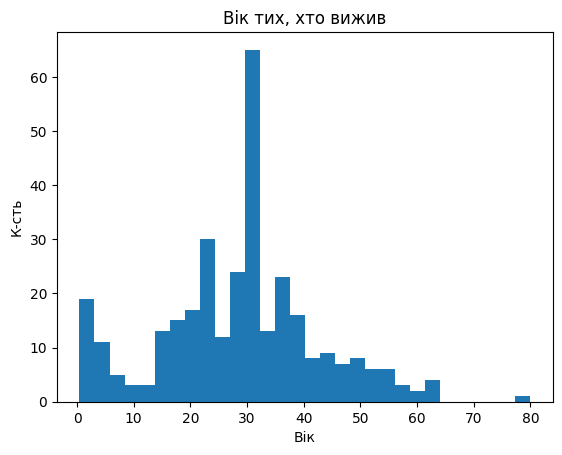

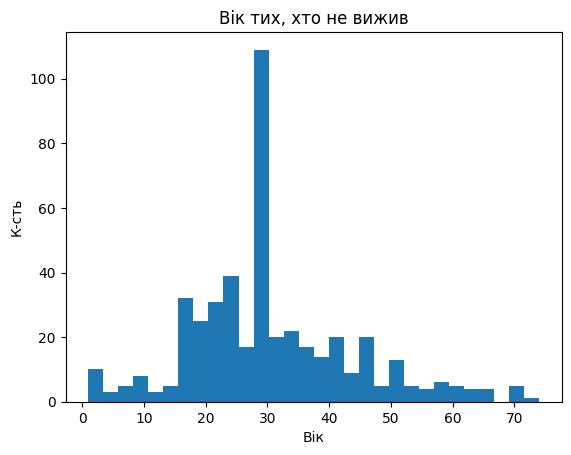

Survival %
Sex Pclass            
0.0 1        37.190083
    2        18.478261
    3        15.827338
1.0 1        96.774194
    2        91.780822
    3        47.244094

,Survived,Pclass,Age,Fare
Survived,1.000000,-0.332658,-0.080527,0.246769
Pclass,-0.332658,1.000000,-0.340711,-0.549216
Age,-0.080527,-0.340711,1.000000,0.089474
Fare,0.246769,-0.549216,0.089474,1.000000


Pclass    0.332658
Name: Survived, dtype: float64


In [32]:
if set(['Survived','Sex']).issubset(subset.columns):
    display((subset.groupby('Sex')['Survived'].mean()*100).to_frame('Survival %'))
if set(['Survived','Pclass']).issubset(subset.columns):
    display((subset.groupby('Pclass')['Survived'].mean()*100).to_frame('Survival %'))
if set(['Survived','Age']).issubset(subset.columns):
    display((subset.groupby('Survived')['Age'].mean()).to_frame('Mean Age'))
if set(['Survived','Fare']).issubset(subset.columns):
    bins = pd.qcut(subset['Fare'], q=4, duplicates='drop')
    display((subset.groupby(bins)['Survived'].mean()*100).to_frame('Survival %'))
if set(['Pclass','Fare']).issubset(subset.columns):
    display((subset.groupby('Pclass')['Fare'].mean()).to_frame('Mean Fare'))
if set(['Pclass','Age']).issubset(subset.columns):
    display((subset.groupby('Pclass')['Age'].mean()).to_frame('Mean Age'))

if set(['Survived','Age']).issubset(subset.columns):
    plt.figure()
    subset[subset['Survived']==1]['Age'].plot(kind='hist', bins=30)
    plt.title('Вік тих, хто вижив')
    plt.xlabel('Вік')
    plt.ylabel('К-сть')
    plt.show()

    plt.figure()
    subset[subset['Survived']==0]['Age'].plot(kind='hist', bins=30)
    plt.title('Вік тих, хто не вижив')
    plt.xlabel('Вік')
    plt.ylabel('К-сть')
    plt.show()

if set(['Survived','Sex','Pclass']).issubset(subset.columns):
    display((subset.groupby(['Sex','Pclass'])['Survived'].mean()*100).to_frame('Survival %'))

corr = subset[['Survived','Pclass','Age','Fare']].corr()
display(corr)
print(corr['Survived'].drop('Survived').abs().sort_values(ascending=False).head(1))

### Висновок до завдання 2
- Дані очищено, сформовано піднабір ознак.
- Жінки та пасажири вищих класів мали вищі шанси на виживання; тариф додатково асоціюється з виживанням.
- Розподіли віку відрізняються між групами вижив/не вижив.